In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import sys
import time
import pickle
import h5py
import hashlib
from pathlib import Path
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

# Build network and simulate

In [2]:
def simulate(monkey, session, block, trials, config='fixed'):
    params = get_params(monkey, session, block, trials, config)
    net = build_network(params)
    sim = nengo.Simulator(net, progress_bar=False)
    data_list = []
    with sim:
        for trial in range(1, params['trials']+1):
            if trial==1 or trial%10==0: print(f"trial {trial}")
            reset_nodes(net, params, trial)
            net.act.set(False)
            sim.run(params['t_iti'])
            set_nodes(net, params, trial)
            sim.run(params['t_cue'])
            net.act.set(True)
            sim.run(params['t_rew'])
            data = get_data(sim, net, params, trial)
            data_list.append(data)
    dataframe = pd.DataFrame(data_list)
    return dataframe
    # return sim, net

In [3]:
def get_params(monkey, session, block, trials=80, config='fixed'):

    params = {
        'monkey':monkey,
        'session':session,
        'block':block,
        'trials':trials,
        'seed_net':int(hashlib.md5(f"{monkey}_{session}".encode()).hexdigest(), 16) % (2**32),
        'seed_rew':int(hashlib.md5(f"{monkey}_{session}_{block}".encode()).hexdigest(), 16) % (2**32),
        't_iti':0.5,
        't_cue':0.5,
        't_rew':1.0,
        'p_rew':0.7,
        'w0':0.5,
        'lr_let':4e-5,
        'lr_loc':2e-5,
        'lr_w':3e-5,
        'ramp':0.2,
        'neurons':1000,
    }

    if config=='fixed':
        params_net = {
            'alpha_v':0.5,
            'gamma_v':1.0,
            'alpha_w':0.4,
            'gamma_w':0.1,
        }
    elif config=='random':
        rng_net = np.random.default_rng(seed=params['seed_net'])
        params_net = {
            'alpha_v':rng_net.uniform(0.4, 0.6),
            'gamma_v':rng_net.uniform(0.9, 1.0),
            'w0':rng_net.uniform(0.4, 0.6),
            'alpha_w':rng_net.uniform(0.3, 0.5),
            'gamma_w':rng_net.uniform(0.05, 0.10),
        }
    params = params | params_net  # combine two parameter dictionaries

    return params

In [4]:
def set_nodes(net, params, trial):
    net.cue.set(trial)
    net.mask_learn.set(trial)
    net.mask_decay.set(trial)
    net.rew.set(trial)
def reset_nodes(net, params, trial):
    net.cue.reset()
    net.mask_learn.reset()
    net.mask_decay.reset()

In [5]:
def get_data(sim, net, params, trial):
    data = {
        'monkey':params['monkey'],
        'session':params['session'],
        'block':params['block'],
        'trial':trial,
        'va':sim.data[net.p_v][-1,0],
        'vb':sim.data[net.p_v][-1,1],
        'vl':sim.data[net.p_v][-1,2],
        'vr':sim.data[net.p_v][-1,3],
        'w':sim.data[net.p_w][-1,0],
        'al':sim.data[net.p_a][-1,0],
        'ar':sim.data[net.p_a][-1,1],
        'w':sim.data[net.p_w][-1,0],
        'rew':sim.data[net.p_rew][-1,0],
        'acc':sim.data[net.p_rew][-1,2],
    }
    return data

In [6]:
def build_network(params):
                
    class CueNode(nengo.Node):
        def __init__(self, params, size_in=0, size_out=2):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='cue')
        def set(self, trial):
            # [1,0] if [A,B]  or  [0,1] if [B,A], serves as a mask for value routing in the network
            self.state[0] = 1 if self.emp.query("trial==@trial")['left'].values[0]=='A' else 0
            self.state[1] = 1 if self.emp.query("trial==@trial")['right'].values[0]=='A' else 0
        def reset(self):
            self.state = np.zeros((self.size_out))
        def step(self, t):
            return self.state

    class ActionNode(nengo.Node):
        def __init__(self, params, size_in=2, size_out=1):
            self.choose = False
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='action')
        def set(self, choose):
            self.choose = choose
            self.state = np.zeros((self.size_out))
        def step(self, t, x):
            aL, aR = x[0], x[1]
            if self.choose and self.state[0]==0:  # make a new choice once
                if aL>aR: self.state[0] = 1
                elif aR>aL: self.state[0] = -1
                else: self.state[0] = 0
            return self.state

    class RewardNode(nengo.Node):
        def __init__(self, params, size_in=1, size_out=3):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.p_rew = params['p_rew']
            self.rng = np.random.default_rng(seed=params['seed_rew'])
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.correct = None
            self.deliver = None
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='reward')
        def set(self, trial):
            self.correct = self.emp.query("trial==@trial")['correct'].values[0]
            self.deliver = self.rng.uniform(0,1) <= self.p_rew
        def step(self, t, x):
            action = x[0]
            if action==0:
                self.state[0] = 0  # rewarded = 1, punished = -1
                self.state[1] = 1  # cue/decision phase = 1, reward pahse = 0
                self.state[2] = 0  # make correct decision = 1, incorrect = -1
            else:
                correct = 1 if self.correct=='left' else -1
                if action==correct and self.deliver:
                    self.state[0] = 1  # yes rewarded for picking the better option
                    self.state[1] = 0  # begin feedback phase
                    self.state[2] = 1  # chose correctly
                if action==correct and not self.deliver:
                    self.state[0] = -1  # not rewarded for picking the better option
                    self.state[1] = 0  # begin feedback phase
                    self.state[2] = 1  # chose correctly
                if action!=correct and not self.deliver:
                    self.state[0] = 1  # yes rewarded for picking the worse option
                    self.state[1] = 0  # begin feedback phase
                    self.state[2] = -1  # chose incorrectly
                if action!=correct and self.deliver:
                    self.state[0] = -1  # not rewarded for picking the worse option
                    self.state[1] = 0  # begin feedback phase
                    self.state[2] = -1  # chose incorrectly
            return self.state

    class MaskLearningNode(nengo.Node):
        def __init__(self, params, size_in=1, size_out=4):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.letter_left, self.letter_right = None, None
            self.left_letter, self.right_letter = None, None
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='mask_learn')
        def set(self, trial):
            self.left_letter = 1 if self.emp.query("trial==@trial")['left'].values[0]=='A' else -1
            self.right_letter = 1 if self.emp.query("trial==@trial")['right'].values[0]=='A' else -1
        def reset(self):
            self.left_letter, self.right_letter = None, None
        def step(self, t, x):
            action = x[0]  # 1 if left is chosen, -1 if right is chosen
            self.state = np.zeros((self.size_out))
            self.state[0] = 1 if (action==1 and self.left_letter==1) or (action==-1 and self.right_letter==1) else 0
            self.state[1] = 1 if (action==1 and self.left_letter==-1) or (action==-1 and self.right_letter==-1) else 0
            self.state[2] = 1 if action==1 else 0
            self.state[3] = 1 if action==-1 else 0
            return self.state
            # [vA, vB, vL, vR]: 1 if learning should occur because letter/loc was chosen, 0 otherwise

    class MaskDecayNode(nengo.Node):
        def __init__(self, params, size_in=1, size_out=4):
            monkey, session, block = params['monkey'], params['session'], params['block']
            self.emp = pd.read_pickle("data/empirical.pkl").query("monkey==@monkey & session==@session & block==@block")
            self.left_letter, self.right_letter = None, None
            self.state = np.zeros((size_out))
            super().__init__(self.step, size_in=size_in, size_out=size_out, label='mask_decay')
        def set(self, trial):
            self.left_letter = 1 if self.emp.query("trial==@trial")['left'].values[0]=='A' else -1
            self.right_letter = 1 if self.emp.query("trial==@trial")['right'].values[0]=='A' else -1
        def reset(self):
            self.left_letter, self.right_letter = None, None
        def step(self, t, x):
            action = x[0]  # 1 if left is chosen, -1 if right is chosen
            self.state = np.ones((self.size_out))
            self.state[0] = 0 if (action==1 and self.left_letter==1) or (action==-1 and self.right_letter==1) else 1
            self.state[1] = 0 if (action==1 and self.left_letter==-1) or (action==-1 and self.right_letter==-1) else 1
            self.state[2] = 0 if action==1 else 1
            self.state[3] = 0 if action==-1 else 1
            return self.state
            # [vA, vB, vL, vR]: 1 if decay should occur because letter/loc was NOT chosen, 0 otherwise

    net = nengo.Network(seed=params['seed_net'])
    with net:
        # INPUTS
        in_f = nengo.Node([0,0,0,0])  # constant vector that provides features for learning values
        in_g = nengo.Node([0])  # constant vector that provides features for learning omega
        in_w = nengo.Node(params['w0'])  # baseline omega
        cue = CueNode(params)  # input trial-specific [Letter L, Letter R]
        rew = RewardNode(params)  # if action has been chosen, return trial-specific reward +/-1, and a generic reward signal: [signed_rew, abs_rew]
        mask_learn = MaskLearningNode(params)  # mask signal used to update the chosen values and locations: [mA, mB, mL, mR]
        mask_decay = MaskDecayNode(params)  # mask signal used to update the unchosen values and locations: [mA, mB, mL, mR] = 1 - mask_learn
        act = ActionNode(params)  # decides whether action values cross action threshold
        
        # ENSEMBLES
        f = nengo.Ensemble(params['neurons'], 4)  # value features
        g = nengo.Ensemble(params['neurons'], 1)  # omega features
        v = nengo.Ensemble(params['neurons'], 4, radius=2)  # learned values: [vA, vB, vL, vR]
        w = nengo.Ensemble(params['neurons'], 1)  # learned omega [w]
        a = nengo.Ensemble(params['neurons'], 2, radius=2)  # accumulated action values [aL, aR]
        afb = nengo.Ensemble(params['neurons'], 3, radius=2)  # controlled integrator: fb=1 causes accumulation, fb=0 causes decay [aL, aR, fb]
        vlet = nengo.Ensemble(params['neurons'], 4, radius=2)  # learned values for letters, masked by letter location on current trial [vA, vB, mL, mR]
        vwa = nengo.Ensemble(params['neurons'], 5, radius=3)  # combined value and omega population: [vLetL, vLetR, vL, vR, w]
        evc = nengo.Ensemble(params['neurons'], 8, radius=4)  # combined error vector for chosen option and mask: [vA-E, vB-E, vL-E, vR-E, mA, mB, mL, mR]
        evu = nengo.Ensemble(params['neurons'], 8, radius=4)  # combined error vector for unchosn option and mask: [vA-E, vB-E, vL-E, vR-E, mA, mB, mL, mR]
        drel = nengo.Ensemble(params['neurons'], 8, radius=4)  # combined value vector for chosen option and mask, for updaing omega: [vA, vB, vL, vR, mA, mB, mL, mR]
        wtar = nengo.Ensemble(params['neurons'], 1)  # target omega value following action and reward  [wtar]
        ewt = nengo.Ensemble(params['neurons'], 1)  # error for omega update  [ew]
        ewd = nengo.Ensemble(params['neurons'], 1)  # error for omega decay  [ew]

        # CONNECTIONS
        # connect feature fectors to value populations and establish the learning connections
        nengo.Connection(in_f, f)
        nengo.Connection(in_g, g)
        cf = nengo.Connection(f[:2], v[:2], synapse=0.01, transform=0, learning_rule_type=nengo.PES(learning_rate=params['lr_let']))  # learned connection for letters
        cf2 = nengo.Connection(f[2:], v[2:], synapse=0.01, transform=0, learning_rule_type=nengo.PES(learning_rate=params['lr_loc']))  # learned connection for locations
        cg = nengo.Connection(g, w, synapse=0.01, function=lambda x: params['w0'], learning_rule_type=nengo.PES(learning_rate=params['lr_w']))  # learned connection for omega

        # combine all values and omega into one population
        nengo.Connection(v[:2], vlet[:2], synapse=0.01)  # [vA, vB]
        nengo.Connection(cue, vlet[2:4])  # [1,0] if [A,B] or [0,1] if [B,A], serves as a mask for value routing in the network
        nengo.Connection(vlet, vwa[0], synapse=0.01, function=lambda x: x[0]*x[2]+x[1]*x[3])  # computes vLetL using above mask
        nengo.Connection(vlet, vwa[1], synapse=0.01, function=lambda x: x[1]*x[2]+x[0]*x[3])  # computes vLetR using above mask
        nengo.Connection(v[2:4], vwa[2:4], synapse=0.01)  # [vL, vL]
        nengo.Connection(w, vwa[4], synapse=0.01)  # [w]

        # compute the overall action values using the arbitration weight
        nengo.Connection(vwa, a[0], synapse=0.01, transform=params['ramp'], function=lambda x: x[0]*x[4]+x[2]*(1-x[4]))  # vLetL*w + vL*(1-w)
        nengo.Connection(vwa, a[1], synapse=0.01, transform=params['ramp'], function=lambda x: x[1]*x[4]+x[3]*(1-x[4]))  # vLetR*w + vR*(1-w)

        # recurrent connect the action population so that it ramps at a rate proportional to the weighted values
        nengo.Connection(a, afb[:2], synapse=0.1)  # action integrator
        nengo.Connection(afb, a, synapse=0.1, function=lambda x: [x[0]*x[2], x[1]*x[2]])  # integrate before action, decay after action: x[2] controls
        nengo.Connection(rew[1], afb[2], synapse=None)  # control feedback based on phase
        nengo.Connection(a, act, synapse=0.01)  # send action values to action node
        nengo.Connection(act, rew, synapse=None)  # send [+/-1] to reward node
        nengo.Connection(act, mask_learn, synapse=None)  # send [+/-1] to learning mask node
        nengo.Connection(act, mask_decay, synapse=None)  # send [+/-1] to decay mask node

        # compute error following choice and reward
        nengo.Connection(v, evc[:4], synapse=0.01)  # [vA, vB, vL, vR]
        nengo.Connection(rew[0], evc[:4], transform=4*[[-1]])  # [-rew, -rew, -rew, -rew]
        nengo.Connection(mask_learn, evc[4:8])  # [mA, mB, mL, mR]
        nengo.Connection(v, evu[:4], synapse=0.01, transform=-1)   # [vA, vB, vL, vR]
        nengo.Connection(mask_decay, evu[4:8])  # [mA, mB, mL, mR]
        nengo.Connection(v, drel[:4], synapse=0.01)   # [vA, vB, vL, vR]
        nengo.Connection(mask_learn, drel[4:8])  # [mA, mB, mL, mR]
        nengo.Connection(drel, wtar, synapse=0.01, function=lambda x: [x[0]*x[4]+x[1]*x[5]-x[2]*x[6]-x[3]*x[7]])  # target omega based on delta reliability
        nengo.Connection(wtar, ewt, synapse=0.01, function=lambda x: 1 if x>0 else 0)  # error for omega = 1-w if drel>0 else 0-w
        nengo.Connection(w, ewt, synapse=0.01, transform=-1)  # omega current
        nengo.Connection(in_w, ewd)  # decay back towards w0
        nengo.Connection(w, ewd, synapse=0.01, transform=-1)  # decay proportional to omega current

        # computed errors drive PES learning
        nengo.Connection(evc, cf.learning_rule, synapse=0.01, transform=params['alpha_v'], function=lambda x: [x[0]*x[4], x[1]*x[5]])  # let learning
        nengo.Connection(evc, cf2.learning_rule, synapse=0.01, transform=params['alpha_v'], function=lambda x: [x[2]*x[6], x[3]*x[7]])  # loc learning
        nengo.Connection(evu, cf.learning_rule, synapse=0.01, transform=-params['gamma_v'], function=lambda x: [x[0]*x[4], x[1]*x[5]])  # let decay
        nengo.Connection(evu, cf2.learning_rule, synapse=0.01, transform=-params['gamma_v'], function=lambda x: [x[2]*x[6], x[3]*x[7]])  # loc decay
        nengo.Connection(ewt, cg.learning_rule, synapse=0.01, transform=-params['alpha_w'])  # omega learning
        nengo.Connection(ewd, cg.learning_rule, synapse=0.01, transform=-params['gamma_w'])  # omega decay

        # inhibit learning and reset unless a reward is being delivered
        nengo.Connection(rew[1], evc.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], evu.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], ewt.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        nengo.Connection(rew[1], ewd.neurons, transform=-1000*np.ones((params['neurons'], 1)))
        
        # probes
        net.p_v = nengo.Probe(v, synapse=0.01)
        net.p_w = nengo.Probe(w, synapse=0.01)
        net.p_a = nengo.Probe(a, synapse=0.01)
        net.p_act = nengo.Probe(act)
        vletout = nengo.Ensemble(1, 2, neuron_type=nengo.Direct())  # readout of vLetL and vLetR
        nengo.Connection(vlet, vletout[0], synapse=0.01, function=lambda x: x[0]*x[2]+x[1]*x[3])
        nengo.Connection(vlet, vletout[1], synapse=0.01, function=lambda x: x[1]*x[2]+x[0]*x[3])
        net.p_vlet = nengo.Probe(vletout)
        net.p_vwa = nengo.Probe(vwa, synapse=0.01)
        net.p_evc = nengo.Probe(evc)
        net.p_evu = nengo.Probe(evu)
        net.p_ewt = nengo.Probe(ewt)
        net.p_ewd = nengo.Probe(ewd)
        net.p_drel = nengo.Probe(drel)
        net.p_cue = nengo.Probe(cue)
        net.p_rew = nengo.Probe(rew)
        net.p_mask_learn = nengo.Probe(mask_learn)
        net.p_mask_decay = nengo.Probe(mask_decay)
        net.s_vwa = nengo.Probe(vwa.neurons, synapse=None)
        net.s_a = nengo.Probe(a.neurons, synapse=None)

        net.cue = cue
        net.act = act
        net.rew = rew
        net.mask_learn = mask_learn
        net.mask_decay = mask_decay
    
        return net

In [17]:
def plot_values(nef_data, x='rev', block_type=None, cor_loc=None, cor_let=None, sharey=False, window_size=5):
    plot_df = nef_data.copy()
    
    # 1. Basic block_type filtering
    if block_type is not None:
        plot_df = plot_df[plot_df['block_type'] == block_type]

    # 2. Reversal Filter: Finds blocks where the RULE switched
    def get_switching_blocks(df, column, initial_rule):
        opposing_map = {'left': 'right', 'right': 'left', 'A': 'B', 'B': 'A'}
        target_rule = opposing_map.get(initial_rule)
        block_groups = df.groupby(['monkey', 'session', 'block'])
        valid_blocks = []
        for name, group in block_groups:
            rules_before = group[group['rev'] < 0][column].unique()
            rules_after = group[group['rev'] >= 0][column].unique()
            if (initial_rule in rules_before) and (target_rule in rules_after):
                valid_blocks.append(name)
        return valid_blocks

    if cor_loc is not None:
        valid_indices = get_switching_blocks(plot_df, 'cor_loc', cor_loc)
        plot_df = plot_df[plot_df.set_index(['monkey', 'session', 'block']).index.isin(valid_indices)]

    if cor_let is not None:
        valid_indices = get_switching_blocks(plot_df, 'cor_let', cor_let)
        plot_df = plot_df[plot_df.set_index(['monkey', 'session', 'block']).index.isin(valid_indices)]

    if plot_df.empty:
        print("No blocks found where the rule switched as specified.")
        return

    # 3. Smoothing Logic (applied per phase to avoid blurring the reversal)
    plot_df['after_rev'] = plot_df['rev'] >= 0
    all_cols = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar', 'acc']
    for col in all_cols:
        plot_df[col] = plot_df.groupby(['monkey', 'session', 'block', 'after_rev'])[col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    # --- Plotting Code ---
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4), sharex=True, sharey=sharey)
    titles = ['Values', 'Weights', 'Actions', 'Outcomes']
    columns = [['va', 'vb', 'vl', 'vr'], ['w'], ['al', 'ar'], ['acc']]
    
    for i, cols in enumerate(columns):
        for j, col in enumerate(cols):
            sns.lineplot(data=plot_df, x=x, y=col, ax=axes[i], label=col)
        axes[i].set_title(titles[i])
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i].set(xlim=[-45,45])

    filter_info = [f"{k}={v}" for k, v in zip(['Type', 'CorLoc', 'CorLet'], [block_type, cor_loc, cor_let]) if v]
    fig.suptitle(f"Model Performance {' (' + ', '.join(filter_info) + ')' if filter_info else ''}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_performance(nef_data, window_size=5):
    emp = pd.read_pickle("data/empirical.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    # Apply smoothing to both dataframes,we group by monkey and block_type so the window doesn't blur different conditions together
    for dataset, target_col in [(emp, 'monkey_accuracy'), (nef_data, 'acc')]:
            # Create a temporary indicator: True if trial is after reversal, We use rev >= 0 (or > 0 depending on your task definition of the first reversal trial)
            dataset['after_rev'] = dataset['rev'] >= 0
            # Now we group by all identifiers PLUS the 'after_rev' flag
            dataset['smoothed_acc'] = dataset.groupby(['monkey', 'block_type', 'session', 'block', 'after_rev'])[target_col].transform(
                lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', ax=axes[0], palette=palette[:2],
                 hue='block_type', style='monkey', hue_order=['what', 'where'], style_order=['V', 'W'])
    axes[0].set_title('Empirical Data')
    axes[0].set(xlim=[-45,45], xlabel='Trial', ylabel='Accuracy')
    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', ax=axes[1], palette=palette[:2],
                 hue='block_type', style='monkey', hue_order=['what', 'where'], style_order=['V', 'W'])
    axes[1].set_title('NEF Model')
    axes[1].set(xlabel='Trial')
    plt.tight_layout()
    plt.show()

# Dynamics

In [10]:
nef_data = simulate('V', 0, 3, trials=11, config='random')

trial 1
trial 10


# Population behavior

In [4]:
def load_nef(folder_path="data/nef/"):
    path = Path(folder_path)
    files = list(path.glob("*.pkl"))
    if not files:
        print(f"No .pkl files found in {folder_path}")
        return pd.DataFrame()
    df_list = [pd.read_pickle(f) for f in files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [9]:
def adjust_df(df):
    df['acc'] = df['acc'].replace(-1, 0)
    df['block_type'] = np.where(df['block'] <= 12, 'what', 'where')
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

In [10]:
nef_data = load_nef()
nef_data = adjust_df(nef_data)

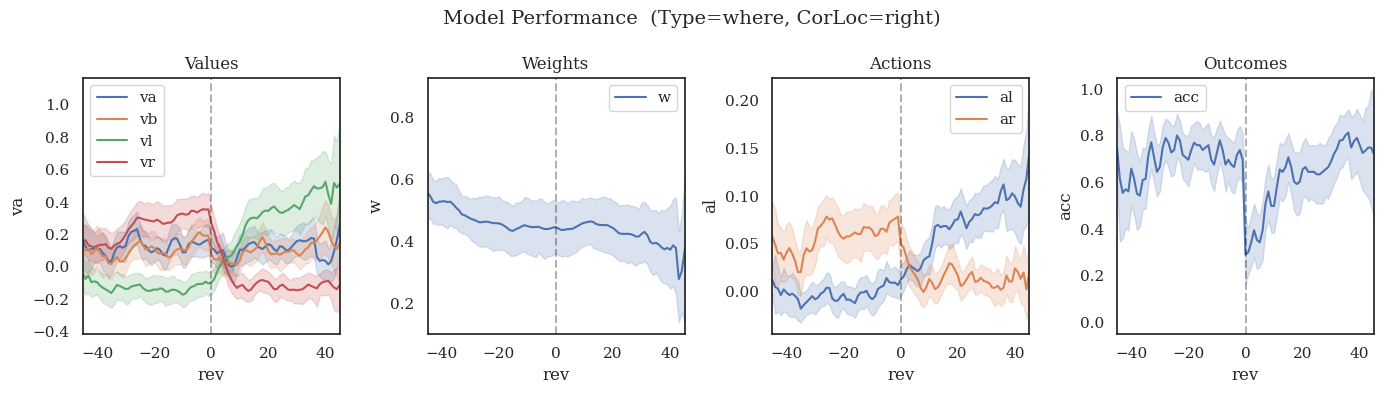

In [19]:
plot_values(nef_data, block_type='where', cor_loc='right', window_size=2)

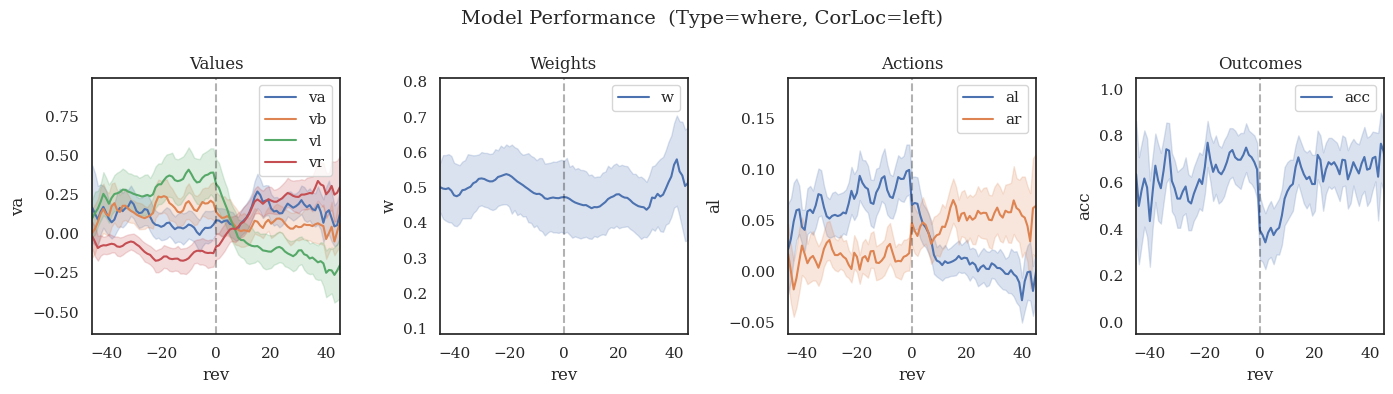

In [21]:
plot_values(nef_data, block_type='where', cor_loc='left', window_size=2)

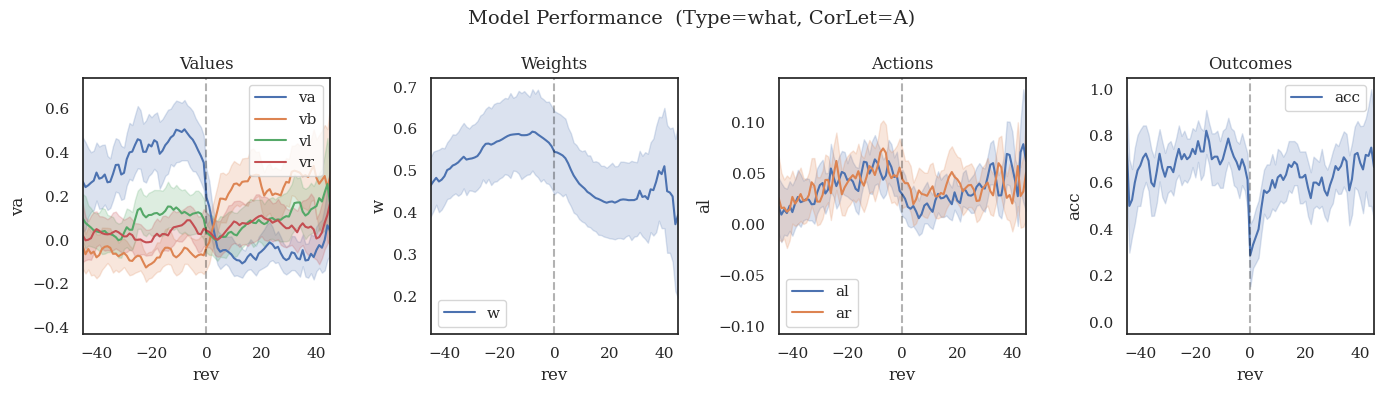

In [22]:
plot_values(nef_data, block_type='what', cor_let='A', window_size=2)

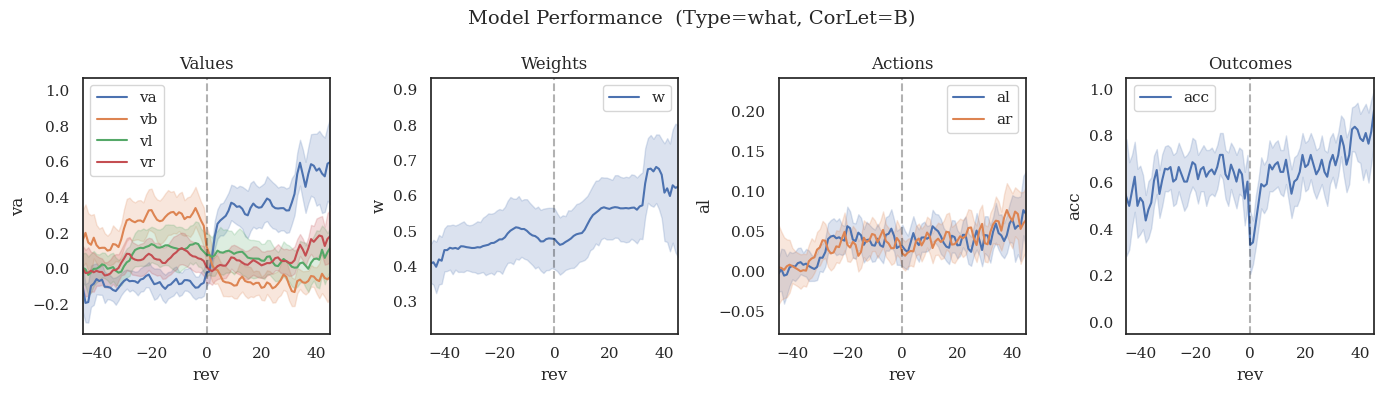

In [23]:
plot_values(nef_data, block_type='what', cor_let='B', window_size=2)

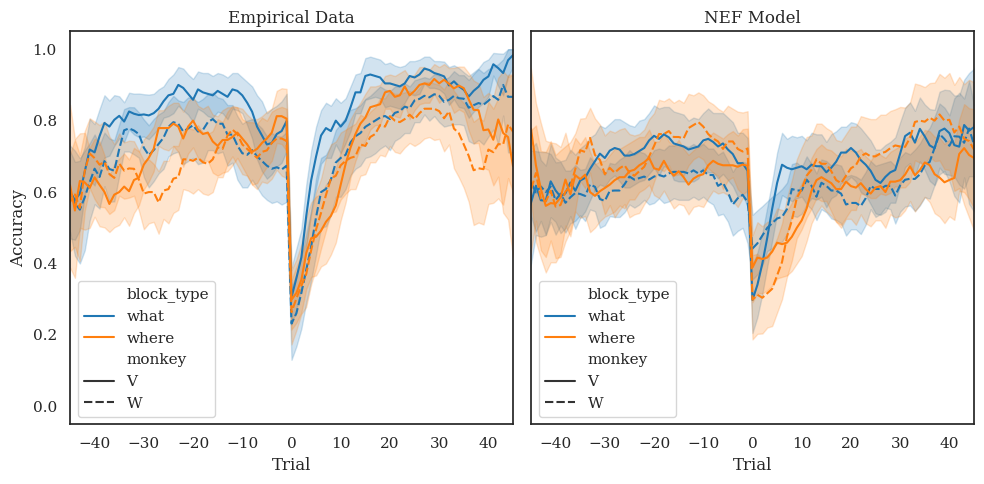

In [24]:
plot_performance(nef_data)